<a href="https://colab.research.google.com/github/dpmallick/BDSN_Project/blob/main/Recommendation_Engine_Pyspark_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#      **Recommendation Engine using ALS(Alternate Least Square Method)**

**Overview**

This was part of Analytics Vidhya Black Friday Sales challenge.

[datahack.analyticsvidhya.com/contest/black-friday/#About](https://)

 Dataset consists of training data and test data. This project will focus only on the three main features i.e user id, Product id, purchase amount. Other user or product related features will be used only for EDA purpose.User related attributes are  age, gender, occupation, marital status, city category they live in and how many years they have been staying there. Product related feature includes product category 1, product category 2 and product category 3. Rating was determined by dividing the purchase amount by 1000 so that rating lies between 1 and 25. Once the model is trained, we would test the model on unseen data (test dataset) to see how good it is able to predict the rating. Test dataset does not having rating column, our model will help to predict the rating in test data. We can also predict the total purchase amount by multiplying the rating with 1000.

# Install and initialize Spark

In [1]:
!apt update > /dev/null
!apt install openjdk-8-jdk-headless -qq > /dev/null
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get latest and correct version of Spark
#
# if the current version of Spark is not used, there may be errors
# check here for current versions http://apache.osuosl.org/spark

!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 198 kB 58.8 MB/s 


In [3]:
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
# note UI port switched from default 4040 to 4050 to avoid clash with ngrok
spark = SparkSession.builder.master("local[*]").config('spark.ui.port', '4050').getOrCreate()
sc = spark.sparkContext

# Lazy Initialization and basic EDA using RDD

Lazy evaluation in Spark means that the execution will not start until an action is triggered. In Spark, the picture of lazy evaluation comes when Spark transformations occur.

In [4]:
# download the train and test data from shared google drive into google colab
!wget -q -O train.csv https://drive.google.com/uc?id=1EovDiFIotRMjbYOHxPhE37E7H8nnjspm&export=download
!wget -q -O test.csv https://drive.google.com/uc?id=1EsUxvxgKAm9VDpULKFv_KkSeTAzyysIU&export=download

In [5]:
 # Read train file
data_file = "/content/train.csv"                     
train_raw_data  = sc.textFile(data_file)
header = train_raw_data.first()
# remove the header line from the train RDD
train_raw_data = train_raw_data.filter(lambda row : row != header)

# Read test file
data_file_1 = "/content/test.csv"
test_raw_data  = spark.sparkContext.textFile(data_file_1)
header1 = test_raw_data.first()
# remove the header line from the RDD
test_raw_data = test_raw_data.filter(lambda row : row != header1)

In [6]:
# Header columns in train file
header

'User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase'

In [7]:
# Total number of records in train dataset
train_raw_data.count()

550068

In [8]:
# Display the first 5 entries in the train dataset
train_raw_data.take(5)

['1000001,P00069042,F,0-17,10,A,2,0,3,,,8370',
 '1000001,P00248942,F,0-17,10,A,2,0,1,6,14,15200',
 '1000001,P00087842,F,0-17,10,A,2,0,12,,,1422',
 '1000001,P00085442,F,0-17,10,A,2,0,12,14,,1057',
 '1000002,P00285442,M,55+,16,C,4+,0,8,,,7969']

In [9]:
# Total number of records in test dataset
test_raw_data.count()

233599

In [10]:
# First five records in test dataset
test_raw_data.take(5)

['1000004,P00128942,M,46-50,7,B,2,1,1,11,',
 '1000009,P00113442,M,26-35,17,C,0,0,3,5,',
 '1000010,P00288442,F,36-45,1,B,4+,1,5,14,',
 '1000010,P00145342,F,36-45,1,B,4+,1,4,9,',
 '1000011,P00053842,F,26-35,1,C,1,0,4,5,12']

In [11]:
# Check the total number of females in the train dataset
trans_female_rdd = train_raw_data.filter(lambda x: 'F' in x)
trans_female_rdd.take(5)
trans_female_rdd.count()


135809

In [12]:
# Get the number of males in the train dataset by subtracting total females from total count
trans_male_rdd = train_raw_data.subtract(trans_female_rdd)
trans_male_rdd.count()

414259

In [13]:
# Split the train RDD by comma and store it in csv_data RDD 
train_csv_data = train_raw_data.map(lambda x: x.split(","))

# Get Number of unique users by reading the 1st column
users = train_csv_data.map(lambda x: x[0]).distinct()
users.collect()

print("Number of unique users in the training set are {}".format(users.count()))

# Get Number of unique products by reading the 2nd column
products = train_csv_data.map(lambda x: x[1]).distinct()
products.collect()

print("Number of unique products in the training set are {}".format(products.count()))

# Build the Cartesian product of User and Product
user_product_combination = users.cartesian(products).collect()
print("There are {} combinations of user X product in the training set are:".format(len(user_product_combination)))

Number of unique users in the training set are 5891
Number of unique products in the training set are 3631
There are 21390221 combinations of user X product in the training set are:


In [14]:
# Infer Schema of train and test csv files using spark read command
train = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("./train.csv")
test = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("./test.csv")

In [15]:
# Display the first entry in the train file
train.head()

Row(User_ID=1000001, Product_ID='P00069042', Gender='F', Age='0-17', Occupation=10, City_Category='A', Stay_In_Current_City_Years='2', Marital_Status=0, Product_Category_1=3, Product_Category_2=None, Product_Category_3=None, Purchase=8370)

In [16]:
# Display the first entry in the test file
test.head()

Row(User_ID=1000004, Product_ID='P00128942', Gender='M', Age='46-50', Occupation=7, City_Category='B', Stay_In_Current_City_Years='2', Marital_Status=1, Product_Category_1=1, Product_Category_2=11, Product_Category_3=None)

In [17]:
# Show total male, female count in each age group
train.crosstab('Age', 'Gender').show()

+----------+-----+------+
|Age_Gender|    F|     M|
+----------+-----+------+
|      0-17| 5083| 10019|
|     46-50|13199| 32502|
|     18-25|24628| 75032|
|     36-45|27170| 82843|
|       55+| 5083| 16421|
|     51-55| 9894| 28607|
|     26-35|50752|168835|
+----------+-----+------+



In [18]:
train_pd = train.toPandas()  

# Further more analysis using SQL

Further analysis was done using SQL so that we can understand the buying patterns based on the input attributes. It will give us some idea
on the different groups and their spending behaviour.

In [19]:
#Creates a temporary view for the training data
train.createOrReplaceTempView("train_table")

#Creates a temporary view for the test data
test.createOrReplaceTempView("test_table")

In [20]:
# Get the highest purchase amount for each age group from the training dataset
spark.sql('select Age, max(Purchase) from train_table group by Age').show()

+-----+-------------+
|  Age|max(Purchase)|
+-----+-------------+
|18-25|        23958|
|26-35|        23961|
| 0-17|        23955|
|46-50|        23960|
|51-55|        23960|
|36-45|        23960|
|  55+|        23960|
+-----+-------------+



In [21]:
# Get the highest, lowest and average purchase amount for each age group from the training dataset
spark.sql('select min(Purchase), max(Purchase), mean(Purchase) from train_table').show()


+-------------+-------------+-----------------+
|min(Purchase)|max(Purchase)|   mean(Purchase)|
+-------------+-------------+-----------------+
|           12|        23961|9263.968712959126|
+-------------+-------------+-----------------+



In [22]:
import pandas as pd
train_pd = train.toPandas()
train_pd.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


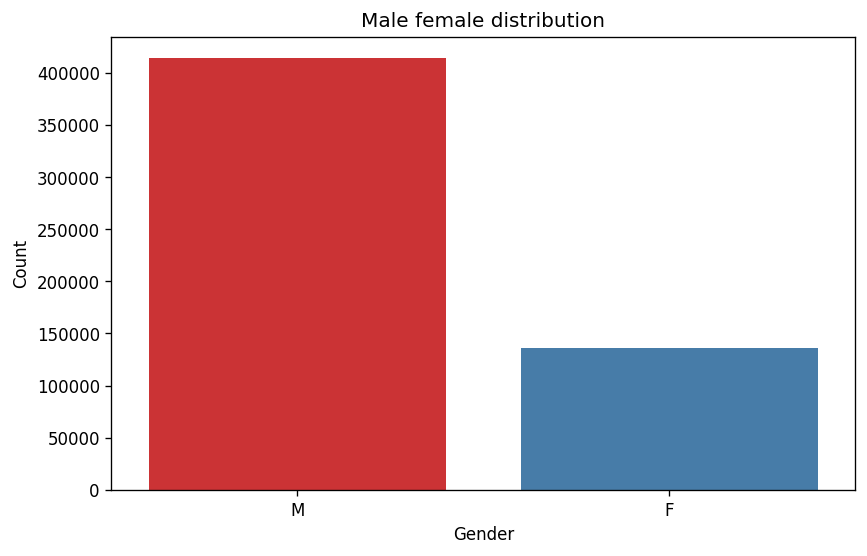

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = train_pd['Gender'].value_counts(),x=train_pd['Gender'].value_counts().index,palette = 'Set1')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Male female distribution')
plt.show()

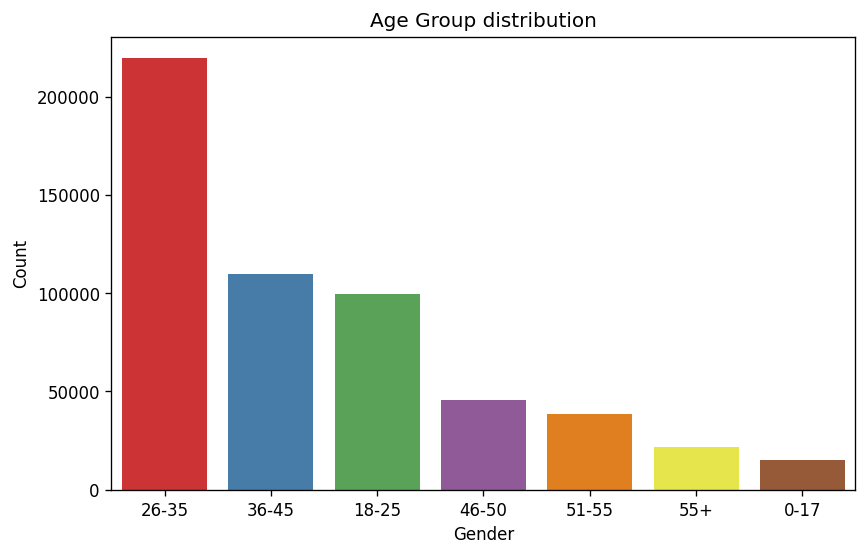

In [24]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = train_pd['Age'].value_counts(),x=train_pd['Age'].value_counts().index,palette = 'Set1')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Age Group distribution')
plt.show()

# Training and evaluating the model

Training the model means ML algorithm finds patterns in the training data and use this knowledge to map the input data attributes/features to the target i.e the answer that it wants to predict. After training, output of the model captures these patterns.

Once model is trained, it has to be evaluated in terms of how well it has managed to predict the correct result. In this case, we will check the RMSE (root mean squared error) score. First the difference between the actual value and predicted value is calculated. Then, it is squared and the then the mean of the square root is found. Best model is the one with lowest RMSE score and which does not have performance issue with minimum set of parameters so that it does not overfit or underfit.





In [25]:
from pyspark.sql.functions import substring, monotonically_increasing_id
import pyspark.sql.functions as f

In [26]:
df_temp  = spark.sql('select user_id as user_id1,product_id as product_key, round(purchase / 1000,2) as rating from train_table')

In [27]:
df_user = df_temp.select("user_id1").distinct().coalesce(1)
df_user = df_user.withColumn("user_id", monotonically_increasing_id()).persist()

In [28]:
df_product = df_temp.select("product_key").distinct().coalesce(1)
df_product = df_product.withColumn("product_id", monotonically_increasing_id()).persist()


In [29]:
df_train = df_temp.join(df_user,"user_id1", "left").join(df_product,"product_key","left")
df_train.show()

+-----------+--------+------+-------+----------+
|product_key|user_id1|rating|user_id|product_id|
+-----------+--------+------+-------+----------+
|  P00069042| 1000001|  8.37|   1787|       730|
|  P00248942| 1000001|  15.2|   1787|      1362|
|  P00087842| 1000001|  1.42|   1787|       152|
|  P00085442| 1000001|  1.06|   1787|      1490|
|  P00285442| 1000002|  7.97|   2620|       927|
|  P00193542| 1000003| 15.23|   1491|      1263|
|  P00184942| 1000004| 19.22|   2957|       907|
|  P00346142| 1000004| 15.85|   2957|      2404|
|   P0097242| 1000004| 15.69|   2957|      2560|
|  P00274942| 1000005|  7.87|    497|      1660|
|  P00251242| 1000005|  5.25|    497|        89|
|  P00014542| 1000005|  3.96|    497|        17|
|  P00031342| 1000005|  6.07|    497|      2476|
|  P00145042| 1000005| 15.67|    497|      1214|
|  P00231342| 1000006|  5.38|   3905|      1980|
|  P00190242| 1000006|  2.08|   3905|      1130|
|   P0096642| 1000006| 13.06|   3905|       129|
|  P00058442| 100000

In [30]:
# Do type conversion, convert product id from string to integer
from pyspark.sql.types import IntegerType

In [31]:
# Read the first entry
df_train.head()

Row(product_key='P00069042', user_id1=1000001, rating=8.37, user_id=1787, product_id=730)

In [32]:
# import the necessary libraries
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf, col, when
import numpy as np

In [33]:
# Set the hyperparameters of ALS
iterations = 10
regularization_parameter = 0.1 # Lambda
rank=5
errors = []
err = 0

# Splitting the training dataset into training and validation dataset in the ration 75:25
df_training, df_validation = df_train.randomSplit([.75, .25])

In [34]:
# Train the model with preset hyperparameters

# initialize the model with the parameters
als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=5, userCol="user_id", itemCol = "product_id", ratingCol="rating")
# fit the model
model = als.fit(df_training)
# predict rating based on validation data
predictions = model.transform(df_validation)
new_predictions = predictions.filter(col('prediction') != np.nan)
# evaluate the RMSE for the rating
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(new_predictions)
print("Root Mean Square Error Value = " + str(rmse))
print("for rank {} Root Mean Square Error Value = {}" .format(rank,rmse))

Root Mean Square Error Value = 2.4797345071771657
for rank 5 Root Mean Square Error Value = 2.4797345071771657


In [35]:
# Optional steps to get the best model by changing the rank hyperparameter
# Runs successfully but commented because since it is time consuming

#iterations=10
#for rank in range(1,15):
  #als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="user_id", itemCol = 'product_id', ratingCol="rating")
  #model = als.fit(df_training)
  #predictions = model.transform(df_validation)
  #new_predictions = predictions.filter(col('prediction') != np.nan)
  #evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
  #rmse = evaluator.evaluate(new_predictions)
  #print("for rank {}, iterations {} Root Mean Square Error Value = {}" .format(rank,iterations,rmse))
  ##print("Root Mean Square Error Value = " + str(rmse))

In [36]:
# Optional steps to get the best model by changing rank and regularization parameter and iterations set to 20
# Runs successfully but commented because since it is time consuming

#iterations = 20
#for rank in range(1,20):
  #for regularization_parameter in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.30]:
    #als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="user_id", itemCol = 'product_id', ratingCol="rating")
    #model = als.fit(df_training)
    #predictions = model.transform(df_validation)
    #new_predictions1 = predictions.filter(col('prediction') != np.nan)
    #evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    #rmse = evaluator.evaluate(new_predictions1)
    #print("for rank {},iteration {}, regularization_parameter {} Root Mean Square Error Value = {}" .format(rank,iterations,regularization_parameter, rmse))
    ##print("Root Mean Square Error Value = " + str(rmse))

# Hyperparameter tuning

Hyperparameter tuning is used to tune the model based on the optimal parameters to find the best performance.

For ALS, main hyperparameters are rank, regularization parameter and maximum iterations.

ALS takes matrix of ratings and will factor that into two different matrices. one representing the user and another one representing the product. In the process of doing this latent features are uncovered. 

**Rank** 
ALS allows us to choose the number of latent features. For meaningful grouping of products to see how similar the products are (or experiment with different number of latent features. If there are too few or too many latent features the groupings might be difficult to understand. So, we need to look at different number of latent features and manually identify what makes the most sense.

**Regularization parameters**  Number added to error metric to keep the algorithm converging too quickly fitting to the training data

**Maximum iterations** is number of items to iterate between factor matrices back and forth adjusting the values to reduct the RMSE. Higher number of iterations longer it will take to complete. Fewer iterations have the risk of not reducing the error.


In [37]:
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, range(4,10)) \
            .addGrid(als.regParam, [.1, .15, .2, 0.3]) \
            .addGrid(als.maxIter, [20]) \
            .build()

In [38]:
# Build cross validation using CrossValidator
evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")
# Check the cross validation score
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [39]:
# fit the model using the combinations provided in the hyperparameter list
cvModel = cv.fit(df_training)


In [40]:
# get the best model along with the best hyperparameter values
best_model = cvModel.bestModel

print(f"Rank = {best_model._java_obj.parent().getRank()}")
print(f"MaxIter = {best_model._java_obj.parent().getMaxIter()}")
print(f"RegParam = {best_model._java_obj.parent().getRegParam()}")

Rank = 4
MaxIter = 20
RegParam = 0.1


# Predict based on Validation data

We will predict based on the validation data and see how well was it able to predict the results

In [41]:
# Fit the model and predictbased on the best tuned hyperparameters
final_als = ALS(maxIter=20, regParam=0.1, rank=4, userCol="user_id", itemCol = 'product_id', ratingCol="rating")
# Fit the model
final_model = final_als.fit(df_training)
# Predict 
predictions = final_model.transform(df_validation)
# Show the first 10 predictions
predictions.show(n=10)

+-----------+--------+------+-------+----------+----------+
|product_key|user_id1|rating|user_id|product_id|prediction|
+-----------+--------+------+-------+----------+----------+
|  P00108142| 1003836|  4.56|   4876|       148| 3.5752532|
|  P00108142| 1001186|  6.06|   2535|       148|  3.293592|
|  P00108142| 1003476|  1.69|    506|       148| 3.3524244|
|  P00038342| 1004277| 12.83|   3841|       463| 11.346268|
|  P00038342| 1000195| 16.48|    164|       463| 10.683357|
|  P00038342| 1003054|  9.63|   1326|       463|  8.823515|
|  P00038342| 1005220|  6.78|   3958|       463| 10.255507|
|  P00038342| 1003884|  6.87|   2316|       463|  8.893773|
|  P00297442| 1001743|  6.52|   5178|       471| 5.2975616|
|  P00297442| 1001198|  9.82|   5543|       471| 10.303121|
+-----------+--------+------+-------+----------+----------+
only showing top 10 rows



In [42]:
#Generate recommendation for top 5 products for all the users
userRecommends = final_model.recommendForAllUsers(5)


In [43]:
# print the schema
userRecommends.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- product_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [44]:
# Display the top 5 product recommendatons suggested by the engine for the first 10 users
userRecommends.select("user_id", "recommendations.product_id").show(10,False)

+-------+------------------------------+
|user_id|product_id                    |
+-------+------------------------------+
|1580   |[2469, 119, 1305, 814, 3084]  |
|4900   |[121, 1782, 2469, 2402, 1557] |
|5300   |[2336, 3172, 3084, 2148, 119] |
|471    |[2469, 1557, 119, 1682, 121]  |
|1591   |[1304, 87, 586, 1213, 289]    |
|4101   |[2469, 1305, 3349, 1682, 1357]|
|1342   |[413, 289, 2148, 1386, 551]   |
|2122   |[2469, 119, 3084, 1557, 814]  |
|2142   |[1305, 1357, 3461, 289, 2469] |
|463    |[1305, 2469, 1357, 3345, 1712]|
+-------+------------------------------+
only showing top 10 rows



In [45]:
# Generate recommendation for top 5 users for all the products
productRecommends = final_model.recommendForAllItems(5)

In [46]:
productRecommends.show(5)

+----------+--------------------+
|product_id|     recommendations|
+----------+--------------------+
|      1580|[{4330, 12.658335...|
|       471|[{735, 12.4676895...|
|      1591|[{4536, 8.670233}...|
|      1342|[{735, 12.311802}...|
|      2122|[{3323, 8.800343}...|
+----------+--------------------+
only showing top 5 rows



In [47]:
# Display the top 5 product recommendatons suggested by the engine for the first 10 users 
productRecommends.select("product_id", "recommendations.user_id").show(10, False)

+----------+------------------------------+
|product_id|user_id                       |
+----------+------------------------------+
|1580      |[4330, 1621, 4065, 196, 1487] |
|471       |[735, 1775, 2401, 129, 1690]  |
|1591      |[4536, 147, 2864, 1690, 740]  |
|1342      |[735, 813, 4412, 740, 3875]   |
|2122      |[3323, 2954, 147, 355, 5841]  |
|2142      |[1621, 1487, 2187, 4330, 4065]|
|463       |[4611, 848, 4678, 3630, 1627] |
|833       |[124, 2948, 3586, 5123, 4447] |
|1645      |[1874, 4065, 4396, 5123, 336] |
|3175      |[147, 3323, 4536, 355, 4447]  |
+----------+------------------------------+
only showing top 10 rows



In [48]:
# Generate top 10 Product recommendations for a specified set of users
#users = train.select("user_id").distinct().limit(3)
#users.show()

users = df_train.select("user_id").distinct().limit(3)
users.show()


+-------+
|user_id|
+-------+
|   2529|
|   2927|
|   2040|
+-------+



In [49]:
# Display the 10 product recommended for the specified users
userSubsetRecs = final_model.recommendForUserSubset(users,10)
userSubsetRecs.select("user_id", "recommendations.product_id"). show(10,False)

+-------+-----------------------------------------------------------+
|user_id|product_id                                                 |
+-------+-----------------------------------------------------------+
|2040   |[1998, 2765, 1931, 536, 1945, 1909, 1304, 1657, 3349, 1923]|
|2529   |[3461, 225, 1998, 1305, 1304, 2893, 2765, 3089, 2025, 1762]|
|2927   |[2469, 119, 1557, 3084, 1682, 814, 1305, 93, 303, 2327]    |
+-------+-----------------------------------------------------------+



In [50]:
# Generate top 10 user recommendations for a specified set of products
products = df_train.select("product_id").distinct().limit(3)
productSubSetRecs = final_model.recommendForItemSubset(products, 10)
productSubSetRecs.select("product_id","recommendations.user_id").show(10,False)

+----------+---------------------------------------------------------+
|product_id|user_id                                                  |
+----------+---------------------------------------------------------+
|1677      |[3323, 2954, 147, 1776, 1065, 704, 5344, 3586, 480, 5123]|
|2453      |[735, 813, 1874, 1723, 4345, 1777, 933, 5016, 3446, 5058]|
|2927      |[1874, 5123, 1166, 4780, 735, 933, 336, 5016, 5058, 1723]|
+----------+---------------------------------------------------------+



# Predict on unseen test data

We will predict the ratings in the test dataset where only user and product related information is available. 

We may also get the purchase amount by multiplying ratings with 1000.

In [51]:
# Build the dataframe
#df_test = spark.sql('select user_id,product_id as product_key, SUBSTRING(product_id, 2, length(product_id)) as product_id from test_table')
df_temp2 = spark.sql('select user_id as user_id1, product_id as product_key from test_table')


In [52]:
df_user_test1 = df_temp2.select("user_id1").distinct().coalesce(1)
#df_user_test1.count()
#df_train = df_temp.join(df_user,"user_id1", "left").join(df_product,"product_key","left")
df_user_test = df_user_test1.join(df_user,"user_id1" ,"left")
df_user_test.show()
#df_user_test = df_user_test.withColumn("user_id", monotonically_increasing_id()).persist()

+--------+-------+
|user_id1|user_id|
+--------+-------+
| 1001129|      4|
| 1001601|      6|
| 1002431|     18|
| 1003031|      8|
| 1003938|     10|
| 1004021|     11|
| 1004666|     13|
| 1005158|     15|
| 1000149|      0|
| 1000190|      1|
| 1002605|      7|
| 1005853|     17|
| 1001139|      5|
| 1004552|     12|
| 1005439|     20|
| 1005697|     16|
| 1004739|     14|
| 1003373|      9|
| 1000636|      2|
| 1005476|     19|
+--------+-------+
only showing top 20 rows



In [53]:
df_product_test1 = df_temp2.select("product_key").distinct().coalesce(1)
#df_product_test1.count()
df_product_test = df_product_test1.join(df_product,"product_key" ,"left")
df_product_test.show()
#df_product_test = df_product_test.withColumn("product_id", monotonically_increasing_id()).persist()

+-----------+----------+
|product_key|product_id|
+-----------+----------+
|  P00281742|         1|
|   P0096342|        10|
|  P00026042|         2|
|   P0098242|         0|
|  P00313242|         8|
|  P00048442|         6|
|  P00323242|        14|
|  P00159842|         4|
|  P00015342|         3|
|  P00146342|        11|
|  P00180642|        12|
|  P00078842|         7|
|  P00162642|         5|
|  P00318342|         9|
|  P00256142|        13|
|  P00162742|        16|
|  P00014542|        17|
|  P00165442|        20|
|  P00119442|        28|
|  P00212242|        19|
+-----------+----------+
only showing top 20 rows



In [54]:
df_test = df_temp2.join(df_user_test,"user_id1", "left").join(df_product_test,"product_key","left")


In [55]:
# Show the first 5 entries
df_test.show(5)

+-----------+--------+-------+----------+
|product_key|user_id1|user_id|product_id|
+-----------+--------+-------+----------+
|  P00015342| 1003486|    121|         3|
|  P00015342| 1001680|    173|         3|
|  P00015342| 1001271|    217|         3|
|  P00015342| 1004784|    262|         3|
|  P00015342| 1002010|    277|         3|
+-----------+--------+-------+----------+
only showing top 5 rows



In [56]:
df_productkey = df_test.filter('user_id==19')

In [57]:
df_productkey.show(10)

+-----------+--------+-------+----------+
|product_key|user_id1|user_id|product_id|
+-----------+--------+-------+----------+
|  P00025542| 1005476|     19|       493|
|  P00051442| 1005476|     19|      2493|
|  P00085342| 1005476|     19|       119|
|  P00087042| 1005476|     19|      3084|
|  P00116142| 1005476|     19|        93|
|  P00150142| 1005476|     19|      1006|
|  P00278642| 1005476|     19|      3352|
|  P00291042| 1005476|     19|      2698|
|  P00320442| 1005476|     19|       928|
|  P00340942| 1005476|     19|      1550|
+-----------+--------+-------+----------+
only showing top 10 rows



In [58]:
#Prediction from test data for user 1005476
product_ids = [493, 119, 3084, 2698, 1550,3352, 93, 1006]
user_ids = [19,19,19,19,19,19,19,19]
new_user_preds = spark.createDataFrame(zip(product_ids,user_ids), schema = ['product_id','user_id'])
new_user_preds.show()

+----------+-------+
|product_id|user_id|
+----------+-------+
|       493|     19|
|       119|     19|
|      3084|     19|
|      2698|     19|
|      1550|     19|
|      3352|     19|
|        93|     19|
|      1006|     19|
+----------+-------+



In [59]:
# Ratings given to the unseen test data
new_predictions = final_model.transform(new_user_preds)
new_predictions.show()

+----------+-------+----------+
|product_id|user_id|prediction|
+----------+-------+----------+
|      3352|     19|  6.819161|
|      1550|     19| 6.3193765|
|       493|     19| 7.9426384|
|        93|     19| 20.579357|
|      2698|     19|  5.923417|
|      3084|     19|  24.71607|
|      1006|     19|  6.593154|
|       119|     19| 23.923994|
+----------+-------+----------+



In [60]:
# Prediction from test data for Product id P00313242
df_userkey = df_test.filter('product_id==8')
df_userkey.show(10)

+-----------+--------+-------+----------+
|product_key|user_id1|user_id|product_id|
+-----------+--------+-------+----------+
|  P00313242| 1000984|     22|         8|
|  P00313242| 1001571|     53|         8|
|  P00313242| 1000549|    103|         8|
|  P00313242| 1002952|    115|         8|
|  P00313242| 1003358|    120|         8|
|  P00313242| 1003112|    198|         8|
|  P00313242| 1004477|    229|         8|
|  P00313242| 1000631|    294|         8|
|  P00313242| 1001036|    359|         8|
|  P00313242| 1004388|    424|         8|
+-----------+--------+-------+----------+
only showing top 10 rows



In [61]:
#Prediction from test data for user 1000010
product_ids = [8, 8, 8, 8, 8,8 , 8, 8]
user_ids = [22,424,294,120,115,198,229,53]
new_prod_preds = spark.createDataFrame(zip(user_ids,product_ids), schema = ['user_id','product_id'])
new_prod_preds.show()

+-------+----------+
|user_id|product_id|
+-------+----------+
|     22|         8|
|    424|         8|
|    294|         8|
|    120|         8|
|    115|         8|
|    198|         8|
|    229|         8|
|     53|         8|
+-------+----------+



In [62]:
# Ratings given to the unseen test data
new_predictions_1 = final_model.transform(new_prod_preds)
new_predictions_1.show()

+-------+----------+----------+
|user_id|product_id|prediction|
+-------+----------+----------+
|     53|         8| 8.1157255|
|    115|         8|  8.145874|
|     22|         8|  7.877562|
|    120|         8|  8.284363|
|    229|         8|  7.897434|
|    198|         8| 6.1736693|
|    424|         8|  8.253785|
|    294|         8|  8.105426|
+-------+----------+----------+

